In [8]:
import tensorflow as tf
import os
import random
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# confere o número de gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# setando o random pra seed

SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [10]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

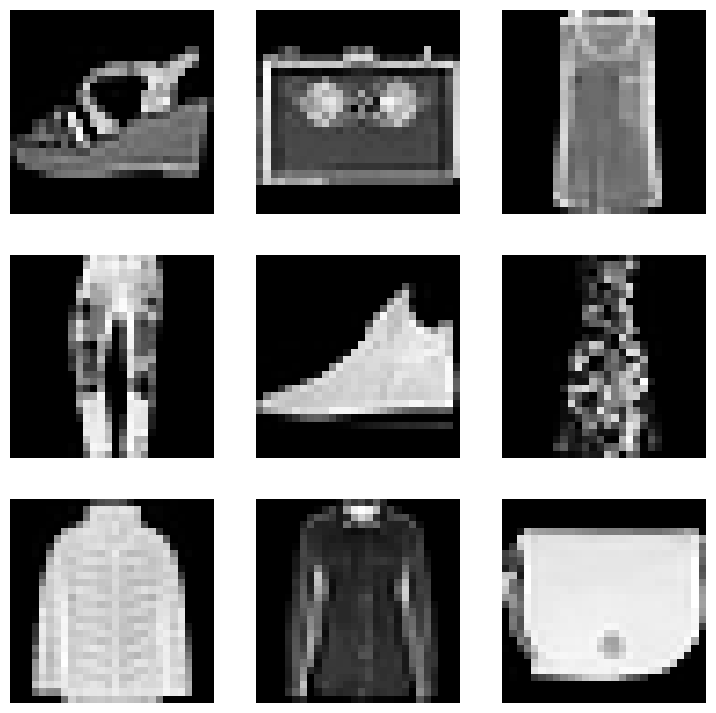

In [11]:
plt.figure(figsize=(9, 9))

# escolhe 9 de 60000 amostras "aleatoriamente" (com seed)
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

In [12]:
# junta pois é de geração de imagens, não de classificação
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255.0

In [13]:
# cria a camada do sampler
class SamplingLayer(layers.Layer):
    """Reparameterization Trick z = mu + sigma * epsilon"""

    def call(self, inputs):
        zMean, zLogVar = inputs
        batch = tf.shape(zMean)[0]
        dim = tf.shape(zMean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [14]:
# ALTERAÇÃO NA REDE CONVOLUCIONAL
def buildEncoder(latentDim, encoderInputs):
    # sem sequential
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(encoderInputs)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # média e log da variância
    zMean = layers.Dense(latentDim, name="z_mean")(x)
    zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

    # reparametrização
    z = SamplingLayer()([zMean, zLogVar])

    return keras.Model(inputs=encoderInputs, outputs=[zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d_4[0][0]']               
                                                                                            

In [15]:
def buildDecoder(latentInputs):
    x = layers.Dense(7*7*64, activation="relu")(latentInputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)

    return keras.Model(inputs=latentInputs, outputs=outputs, name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        577 

In [16]:
# loss
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [17]:
# loss
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

In [18]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [19]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder  # define o encoder
    self.decoder = decoder  # define o decoder

    # registra métricas de perda
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    # retorna as métricas para monitoramento
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):
    # grava os gradientes das operações dentro do contexto
    with tf.GradientTape() as tape:
        # passa os dados pelo encoder
        zMean, zLogVar, z = self.encoder(data)
        # reconstrói a entrada com o decoder
        reconstruction = self.decoder(z)
        # calcula as perdas
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

    # calcula os gradientes
    grads = tape.gradient(totalLoss, self.trainable_weights)
    # aplica os gradientes para atualizar os pesos
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # atualiza os valores das métricas
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # retorna os valores das métricas
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }


In [20]:
vae = VAE(encoder, decoder)  # instancia o modelo
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))  # define otimizador
history = vae.fit(dataset, epochs=16, batch_size=128)  # treina o modelo

Epoch 1/16
547/547 [==============================] - 20s 21ms/step - total_loss: 309.3033 - ce_loss: 297.6022 - kl_loss: 3.9004
Epoch 2/16
547/547 [==============================] - 11s 20ms/step - total_loss: 278.0409 - ce_loss: 264.4171 - kl_loss: 4.5412
Epoch 3/16
547/547 [==============================] - 10s 19ms/step - total_loss: 275.0681 - ce_loss: 261.1394 - kl_loss: 4.6428
Epoch 4/16
547/547 [==============================] - 9s 16ms/step - total_loss: 273.5175 - ce_loss: 259.3132 - kl_loss: 4.7347
Epoch 5/16
547/547 [==============================] - 8s 15ms/step - total_loss: 272.3240 - ce_loss: 257.8964 - kl_loss: 4.8092
Epoch 6/16
547/547 [==============================] - 9s 17ms/step - total_loss: 271.4933 - ce_loss: 256.9270 - kl_loss: 4.8554
Epoch 7/16
547/547 [==============================] - 10s 18ms/step - total_loss: 270.8417 - ce_loss: 256.1169 - kl_loss: 4.9082
Epoch 8/16
547/547 [==============================] - 9s 17ms/step - total_loss: 270.0516 - ce_loss:

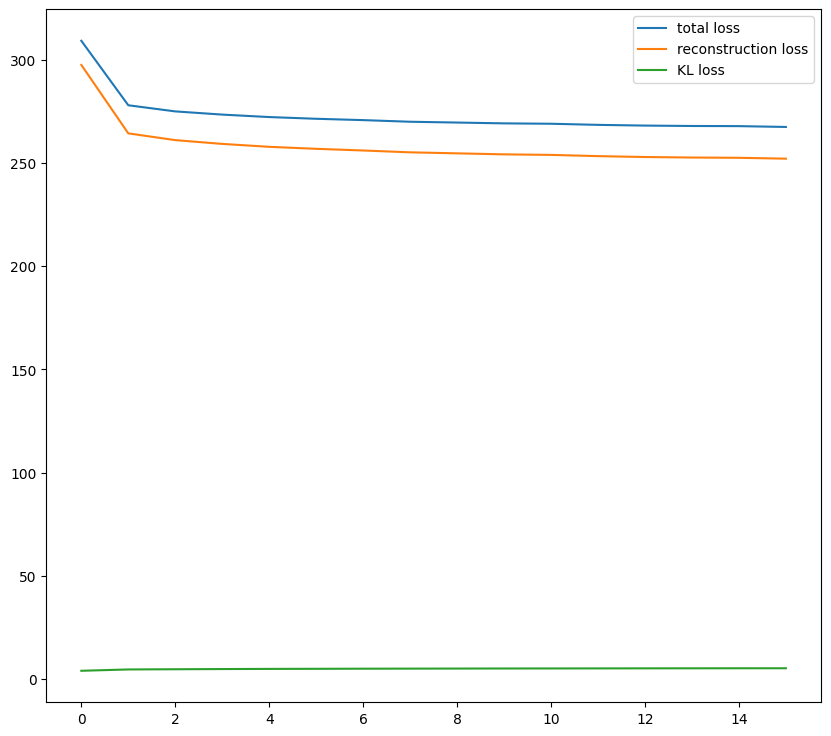

In [21]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

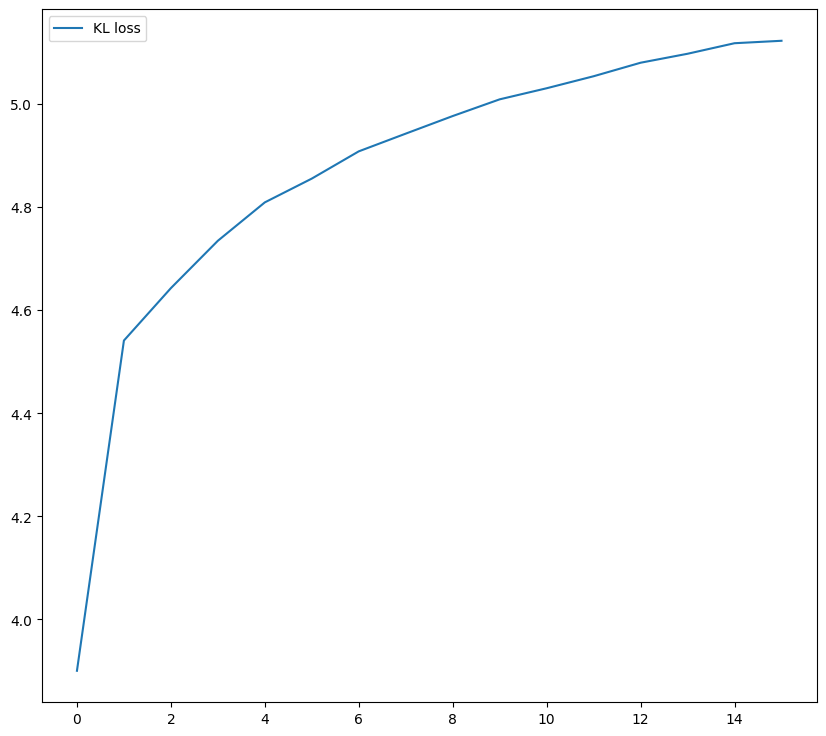

In [22]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

1/1 [==============================] - 0s 153ms/step


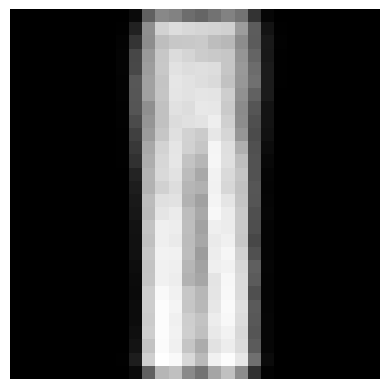

In [23]:
synth = vae.decoder.predict(np.array([[1, 2]]))
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

8/8 [==============================] - 0s 3ms/step


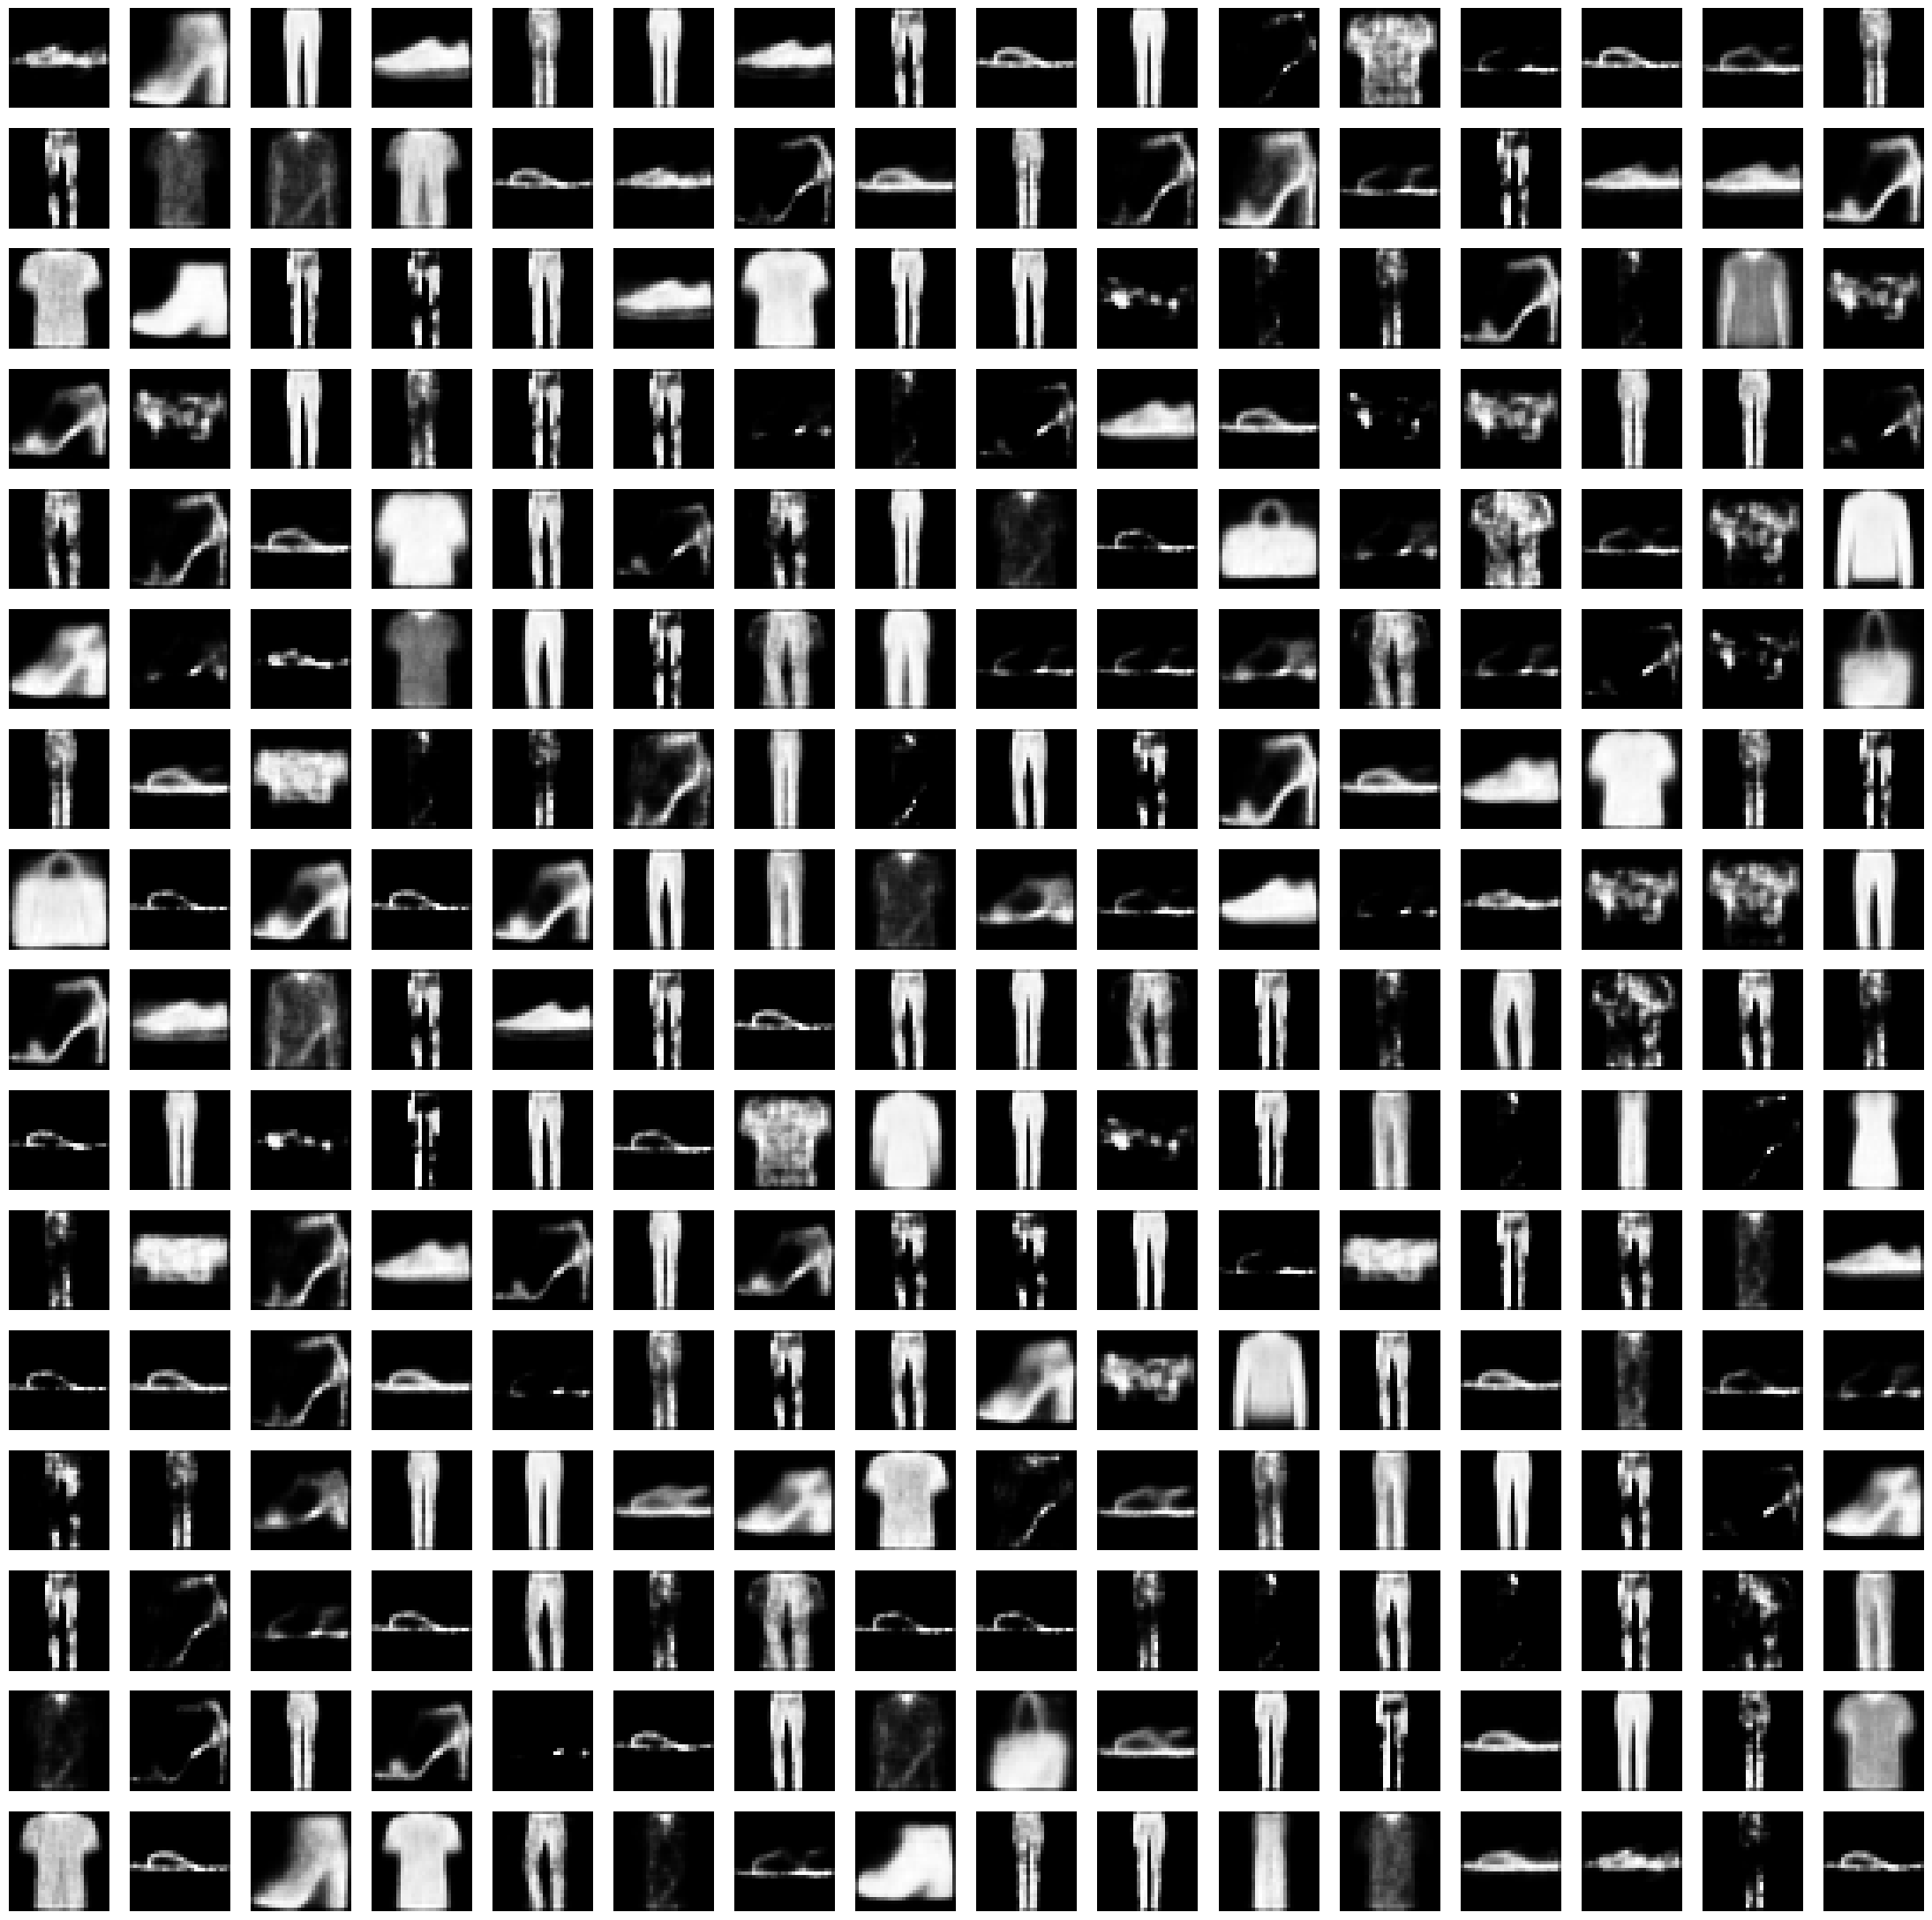

In [24]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [25]:
idx = 1280  # índice da imagem no dataset
batch = np.expand_dims(x_train[idx], axis=0)  # adiciona dimensão batch
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255  # normaliza

print(batchOfImages.shape)  # exibe formato do batch

# obtém z(mu, sigma) para a imagem fornecida
_, _, z = vae.encoder.predict(batchOfImages)

# reconstrói uma imagem similar
synth = vae.decoder.predict([z])

z  # retorna o vetor

(1, 28, 28, 1)
1/1 [==============================] - 0s 91ms/step


array([[0.12849164, 1.4378892 ]], dtype=float32)

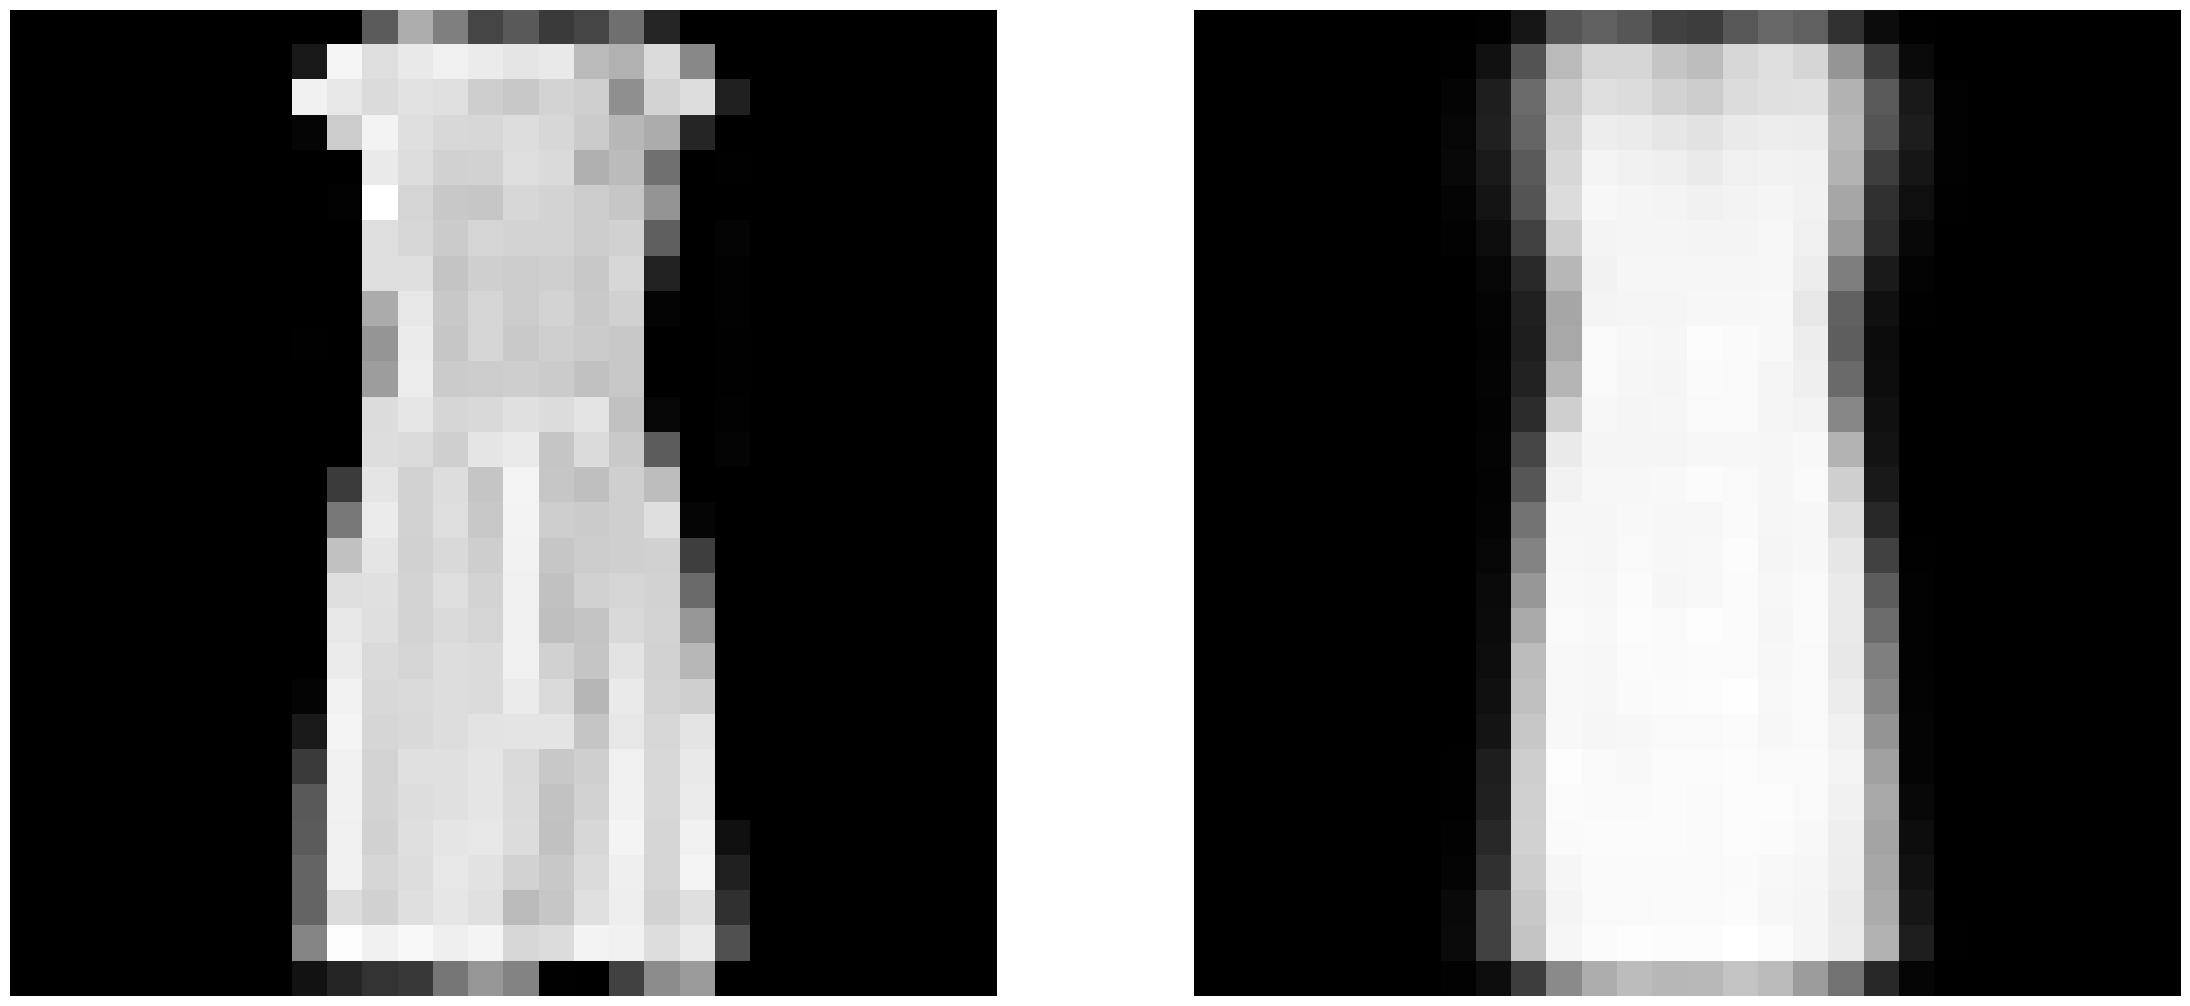

In [26]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 [==============================] - 4s 2ms/step


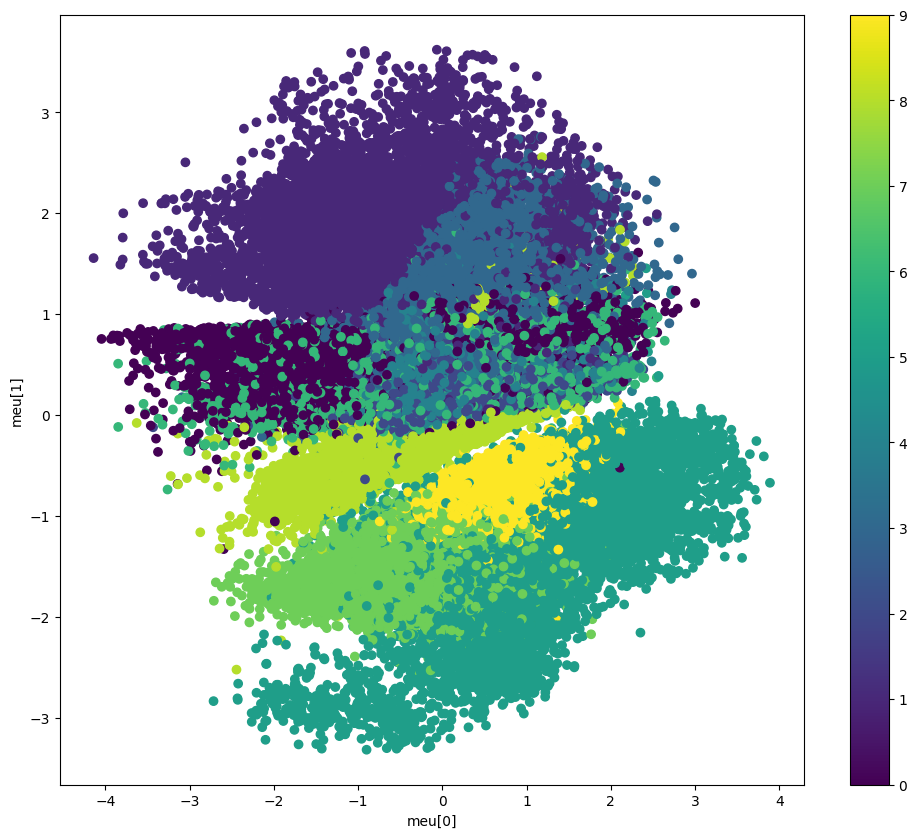

In [27]:
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();